In [1]:
# Graphing
import json
import requests
from datetime import datetime
import time
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from config import (consumer_key, consumer_secret,
                    access_token, access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser(),
                 wait_on_rate_limit=False, wait_on_rate_limit_notify=False)

# Import and Initialize Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

In [2]:
# Read all movie data csv
movie_data_df = pd.read_csv('all_movie_data/all_movie_data.csv')

# Subset df for tweet counts greater than 10
movie_data_df = movie_data_df.loc[(movie_data_df['tweet_count']>10)]
movie_data_df.head()

,title,genre,release,rated,value,budget,opening,domestic,worldwide,ratio,zrating,zbudget,zopening,ztotal,compound,tweet_count
3,#TheEmojiMovie,Adventure,20170728,PG,17.00,50000000,24531923,86089513,216807482,0.490638,-2.055653,-0.016401,0.130480,-0.339178,0.013807,46
4,#JustGettingStarted,Comedy,20171208,PG-13,22.00,22000000,3201459,6069605,6709821,0.145521,-1.807705,-0.490030,-0.494660,-2.850492,0.253185,100
5,#Rings,Horror,20170203,PG-13,25.67,25000000,13002632,27793018,82991460,0.520105,-1.625711,-0.439284,-0.207413,-0.919505,0.182646,96
6,#TheSnowman,Thriller/Suspense,20171020,R,27.00,35000000,3372565,6670765,43232849,0.096359,-1.559757,-0.270131,-0.489645,-2.520101,0.192430,100
7,#Geostorm,Action,20171020,PG-13,29.33,100000000,13707376,33700160,220800160,0.137074,-1.444214,0.829364,-0.186759,-0.577146,-0.024243,100


In [3]:
genres = movie_data_df['genre'].unique()

groupedGenre = movie_data_df.groupby(['genre'])

groupedBudget = groupedGenre['budget'].sum()

groupedOpen = groupedGenre['opening'].sum()

groupedSummary = pd.DataFrame({"budget":groupedBudget, 
                               "opening":groupedOpen})

# Index by title
title_index_df = movie_data_df.set_index(['title'])

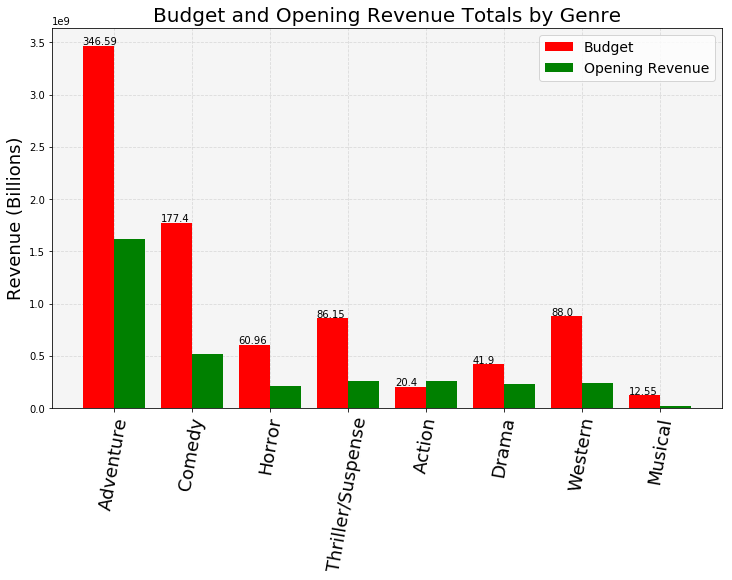

In [4]:
#1 matt: compare revenue and opening weekend revenue sorted by genre
plt.figure(figsize=(12, 7))

plt.bar(np.arange(len(groupedSummary))-.20, groupedSummary['budget'], color = "red", width = .4, label = "Budget")
plt.bar(np.arange(len(groupedSummary))+.20, groupedSummary['opening'], color = "green", width = .4, label = "Opening Revenue")

tick_location = np.arange(len(groupedSummary))
plt.xticks(tick_location, genres, rotation=80, fontsize=18)

plt.title("Budget and Opening Revenue Totals by Genre", fontsize=20)
# plt.xlabel("Genre", fontsize=18)
plt.ylabel("Revenue (Billions)", fontsize=18)

plt.legend(fontsize=14)

# Set axes background color
ax = plt.gca()
ax.set_facecolor('whitesmoke')

# Add values above the two bar graphs
count = 0
for num in groupedSummary['budget']:
    plt.text(count-0.4, num+10050000, str(round(num/10000000,2)))
    count = count + 1

# Insert grid lines and set behind plot elements
ax.grid(linestyle='--', color='lightgrey', alpha=0.8)
ax.set_axisbelow(True)

plt.savefig("images/GenreBudgetRevenue.png", bbox_inches="tight")
plt.show()

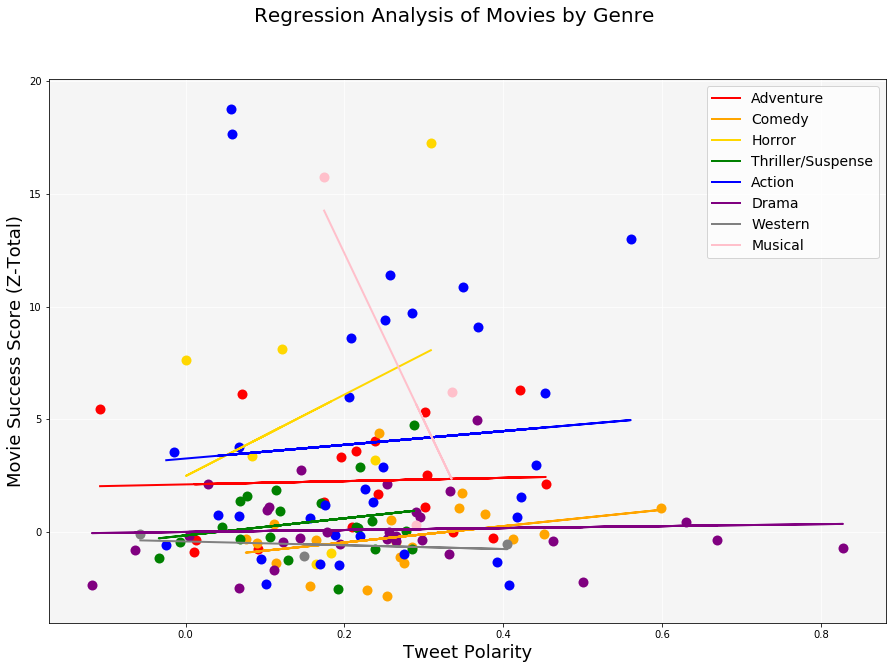

In [5]:
#2 genre sentiment vs score with regression
colors = ["red","orange","gold","green","blue","purple","grey","pink","black","brown"]
g_list = []

fig, gx = plt.subplots(figsize=(15, 10))

for x in np.arange(len(genres)):
    g = genres[x]
    genre = movie_data_df.loc[(movie_data_df['genre'] == g)]
    (gslope, gintercept, _, _, _) = stats.linregress(genre['compound'], genre['ztotal'])
    gfit = (gslope * genre['compound']) + gintercept
    g_dict = {"genre": g, "slope":gslope, "intercept":gintercept}
    g_list.append(g_dict)
    gx.plot(genre['compound'], gfit, color = colors[x], label = g, linewidth = 2)
    gx.scatter(genre['compound'], genre['ztotal'], s = 100, linewidth=0, marker="o", color=colors[x], label = None)
    gx.set_ylabel("Movie Success Score (Z-Total)", size=18)
    gx.set_xlabel("Tweet Polarity", size=18)
    gx.legend (loc='best', bbox_to_anchor=(1,1), fontsize=14)
    fig.suptitle('Regression Analysis of Movies by Genre', size=20)
    
g_df = pd.DataFrame(g_list)

# Set axes background color
ax = plt.gca()
ax.set_facecolor('whitesmoke')

# Insert grid lines and set behind plot elements
ax.grid(color='white')
ax.set_axisbelow(True)

plt.savefig("images/GenreSentimentVsScoreRegression.png")
plt.show()

In [6]:
# Check rate of movie success
g_df.head(10)

,genre,intercept,slope
0,Adventure,2.118653,0.726482
1,Comedy,-1.182845,3.628923
2,Horror,2.485541,18.079104
3,Thriller/Suspense,-0.144233,3.797318
4,Action,3.265835,3.042491
5,Drama,0.009749,0.430808
6,Western,-0.411192,-0.840363
7,Musical,27.198637,-74.116197


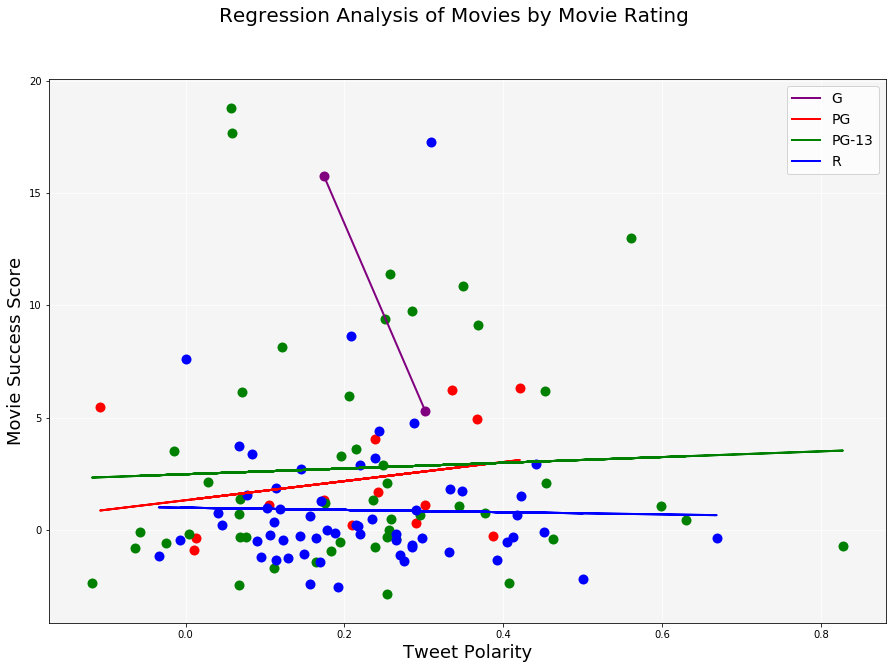

In [7]:
#3 Matt: rated vs. success score with regression
colors = ["purple","red","green","blue"]
rated = ["G","PG","PG-13","R"]
r_list = []

fig, rx = plt.subplots(figsize=(15, 10))
# plt.figure(figsize=(10,7))

for x in np.arange(len(rated)):
    r = rated[x]
    rate = movie_data_df.loc[(movie_data_df['rated'] == r)]
    (rslope, rintercept, _, _, _) = stats.linregress(rate['compound'], rate['ztotal'])
    rfit = (rslope * rate['compound']) + rintercept
    r_dict = {"rated": r, "slope":rslope, "intercept":rintercept}
    r_list.append(r_dict)
    rx.plot(rate['compound'], rfit, color = colors[x], label = r, linewidth = 2)
    rx.scatter(rate['compound'], rate['ztotal'], s = 100, linewidth=0, marker="o", color=colors[x], label = None)
    rx.set_ylabel("Movie Success Score", size=18)
    rx.set_xlabel("Tweet Polarity", size=18)
    rx.legend (loc='best', bbox_to_anchor=(1,1), fontsize=14)
    fig.suptitle('Regression Analysis of Movies by Movie Rating',size=20)

r_df = pd.DataFrame(r_list)

# Set axes background color
ax = plt.gca()
ax.set_facecolor('whitesmoke')

# Insert grid lines and set behind plot elements
ax.grid(color='white')
ax.set_axisbelow(True)

plt.savefig("images/RatedSentimentVsScoreRegression.png")
plt.show()

In [8]:
r_df[['rated','slope','intercept']]
r_df.head()

,intercept,rated,slope
0,30.032923,G,-81.923182
1,1.331664,PG,4.251304
2,2.488874,PG-13,1.270678
3,0.998000,R,-0.493601


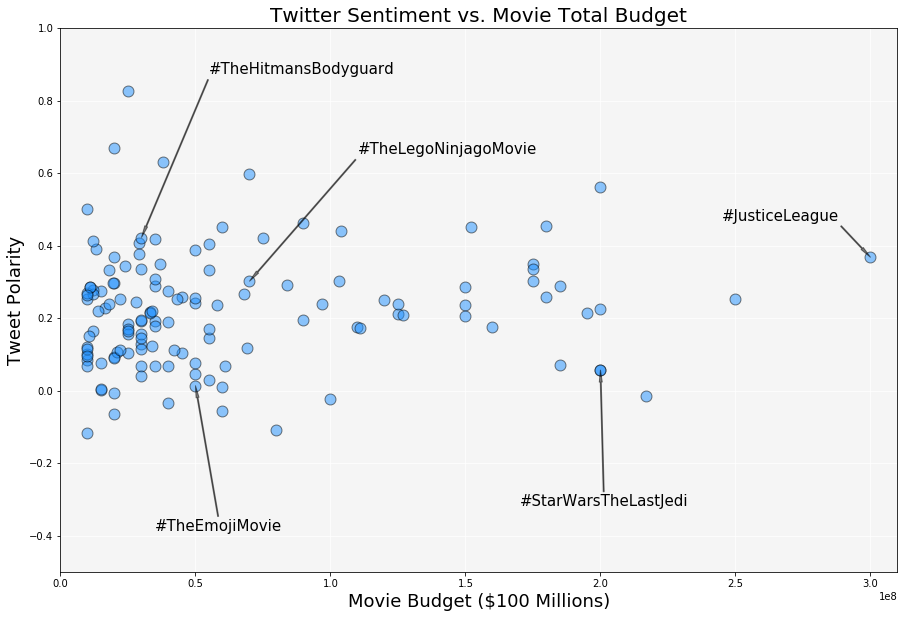

In [9]:
#4 Jason: Vader Sentiment vs. Movie Total Budget
#Does Spending more on a movie, give it better twitter reviews?

# Set movie coordinates
movie_list = ["#TheEmojiMovie", "#JusticeLeague", "#StarWarsTheLastJedi", 
              "#TheHitmansBodyguard", "#TheLegoNinjagoMovie"]

plt.figure(figsize=(15, 10))
plt.ylim(-.5, 1)
plt.xlim(0, 310000000)

plt.scatter(movie_data_df["budget"], movie_data_df["compound"] ,linewidths = 1, alpha= .5, color = 'dodgerblue',edgecolor='black',s=120)

plt.title("Twitter Sentiment vs. Movie Total Budget", fontsize=20)
plt.xlabel("Movie Budget ($100 Millions)", fontsize=18)
plt.ylabel("Tweet Polarity", fontsize=18)

# Set axes background color
ax = plt.gca()
ax.set_facecolor('whitesmoke')

# Insert grid lines and set behind plot elements
ax.grid(color='white')
ax.set_axisbelow(True)

# Dictionary to hold coordinates for each movie
movie_coord = {}

# Grab coordinates
for movie in movie_list:
    
    # Pinpoint values for coordinates
    coordinate_values = title_index_df.loc[movie,['budget', 'compound']]
    
    # Assign coordinates
    x_coord = coordinate_values['budget']
    y_coord = coordinate_values['compound']
    
    # Add coordinates for each movie to dictionary
    movie_coord[movie] = [x_coord, y_coord]

# Annotations
ax.annotate("#TheEmojiMovie", xy=(movie_coord["#TheEmojiMovie"][0], movie_coord["#TheEmojiMovie"][1]), 
            xytext=(movie_coord["#TheEmojiMovie"][0]-15000000, movie_coord["#TheEmojiMovie"][1]-0.4), 
            fontsize=15, arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))
ax.annotate("#JusticeLeague", xy=(movie_coord["#JusticeLeague"][0], movie_coord["#JusticeLeague"][1]), 
            xytext=(movie_coord["#JusticeLeague"][0]-55000000, movie_coord["#JusticeLeague"][1]+0.1), 
            fontsize=15, arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))
ax.annotate("#StarWarsTheLastJedi", xy=(movie_coord["#StarWarsTheLastJedi"][0], movie_coord["#StarWarsTheLastJedi"][1]), 
            xytext=(movie_coord["#StarWarsTheLastJedi"][0]-30000000, movie_coord["#StarWarsTheLastJedi"][1]-0.375), 
            fontsize=15, arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))
ax.annotate("#TheHitmansBodyguard", xy=(movie_coord["#TheHitmansBodyguard"][0], movie_coord["#TheHitmansBodyguard"][1]), 
            xytext=(movie_coord["#TheHitmansBodyguard"][0]+25000000, movie_coord["#TheHitmansBodyguard"][1]+0.45), 
            fontsize=15, arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))
ax.annotate("#TheLegoNinjagoMovie", xy=(movie_coord["#TheLegoNinjagoMovie"][0], movie_coord["#TheLegoNinjagoMovie"][1]), 
            xytext=(movie_coord["#TheLegoNinjagoMovie"][0]+40000000, movie_coord["#TheLegoNinjagoMovie"][1]+0.35), 
            fontsize=15, arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))

# Save and show
plt.savefig("images/BudgetVsTwitterSentiment.png", bbox_inches="tight")
plt.show()

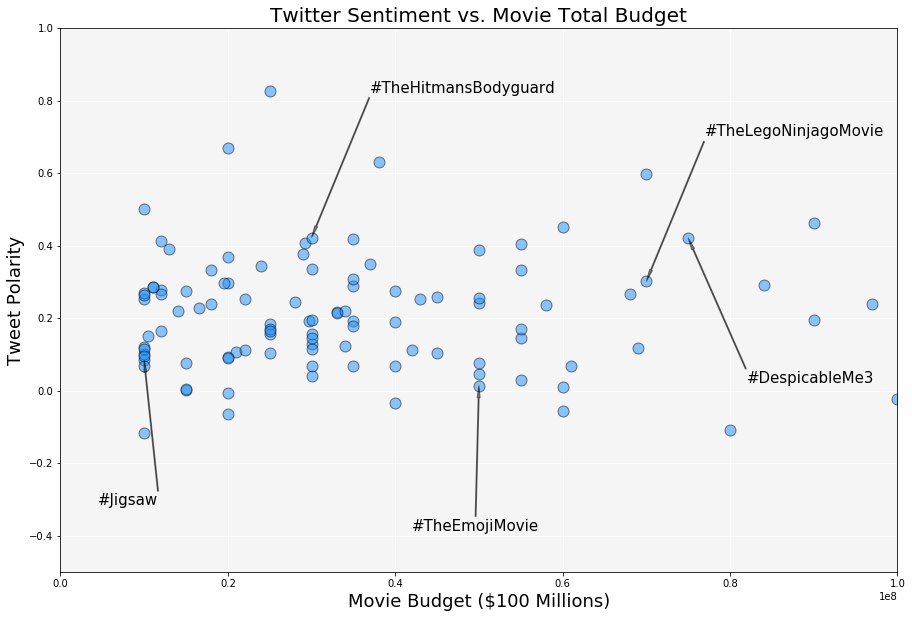

In [10]:
#5 Jason: Is our score able to predict success, based on opening weekend revenue? zoomed

movie_list = ["#TheEmojiMovie", "#DespicableMe3", "#Jigsaw", 
              "#TheHitmansBodyguard", "#TheLegoNinjagoMovie"]

plt.figure(figsize=(15, 10))
plt.ylim(-.5, 1)
plt.xlim(0, 100000000)

plt.scatter(movie_data_df["budget"], movie_data_df["compound"] ,linewidths = 1, alpha= .5, color = 'dodgerblue',edgecolor='black',s=120)

plt.title("Twitter Sentiment vs. Movie Total Budget", fontsize=20)
plt.xlabel("Movie Budget ($100 Millions)", fontsize=18)
plt.ylabel("Tweet Polarity", fontsize=18)

# Set axes background color
ax = plt.gca()
ax.set_facecolor('whitesmoke')

# Insert grid lines and set behind plot elements
ax.grid(color='white')
ax.set_axisbelow(True)

# Dictionary to hold coordinates for each movie
movie_coord = {}

# Grab coordinates
for movie in movie_list:
    
    # Pinpoint values for coordinates
    coordinate_values = title_index_df.loc[movie,['budget', 'compound']]
    
    # Assign coordinates
    x_coord = coordinate_values['budget']
    y_coord = coordinate_values['compound']
    
    # Add coordinates for each movie to dictionary
    movie_coord[movie] = [x_coord, y_coord]

# Annotations
ax.annotate("#TheEmojiMovie", xy=(movie_coord["#TheEmojiMovie"][0], movie_coord["#TheEmojiMovie"][1]), 
            xytext=(movie_coord["#TheEmojiMovie"][0]-8000000, movie_coord["#TheEmojiMovie"][1]-0.4), 
            fontsize=15, arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))
ax.annotate("#DespicableMe3", xy=(movie_coord["#DespicableMe3"][0], movie_coord["#DespicableMe3"][1]), 
            xytext=(movie_coord["#DespicableMe3"][0]+7000000, movie_coord["#DespicableMe3"][1]-0.4), 
            fontsize=15, arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))
ax.annotate("#Jigsaw", xy=(movie_coord["#Jigsaw"][0], movie_coord["#Jigsaw"][1]), 
            xytext=(movie_coord["#Jigsaw"][0]-5500000, movie_coord["#Jigsaw"][1]-0.4), 
            fontsize=15, arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))
ax.annotate("#TheHitmansBodyguard", xy=(movie_coord["#TheHitmansBodyguard"][0], movie_coord["#TheHitmansBodyguard"][1]), 
            xytext=(movie_coord["#TheHitmansBodyguard"][0]+7000000, movie_coord["#TheHitmansBodyguard"][1]+0.4), 
            fontsize=15, arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))
ax.annotate("#TheLegoNinjagoMovie", xy=(movie_coord["#TheLegoNinjagoMovie"][0], movie_coord["#TheLegoNinjagoMovie"][1]), 
            xytext=(movie_coord["#TheLegoNinjagoMovie"][0]+7000000, movie_coord["#TheLegoNinjagoMovie"][1]+0.4), 
            fontsize=15, arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))

plt.savefig("images/BudgetVsTwitterSentimentZoomed.png", bbox_inches="tight")
plt.show()

In [11]:
#6 Shilpa Revenue by Month
sns.set_style("dark", {'grid.linestyle': '--'})
paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2} 
sns.set(rc={'figure.figsize':(15, 10)})

# locating tweet count>10
movie_data_tc10_df = movie_data_df.loc[(movie_data_df['tweet_count']>10)]
movie_data_tc10_df.head()

for index,row in movie_data_tc10_df.iterrows():
    date =str(row['release'])
    year = date[:4]
    month = date[4:6]
    year_month = str(year) + str(month)
    
    #print(month)
    movie_data_tc10_df.set_value(index,'release', str(year_month))
    #movie_data_tc10_df['release'].apply(lambda year_month: datetime.strptime(str(year_month),'%Y%m'))
# movie_data_tc10_df.head()
# y-axis for the plot (opening weekend revenue)
opening_weekend_rev = movie_data_tc10_df.groupby(movie_data_tc10_df["release"])["opening"].sum()
opening_weekend_rev_df = pd.DataFrame(opening_weekend_rev)
opening_weekend_rev_df = opening_weekend_rev.reset_index()
opening_weekend_rev_df.rename(columns={"opening": "total opening by month"}, inplace=True)
opening_weekend_rev_df["release"] = opening_weekend_rev_df["release"].astype(str)
#print(opening_weekend_rev_df.dtypes)
# opening_weekend_rev_df

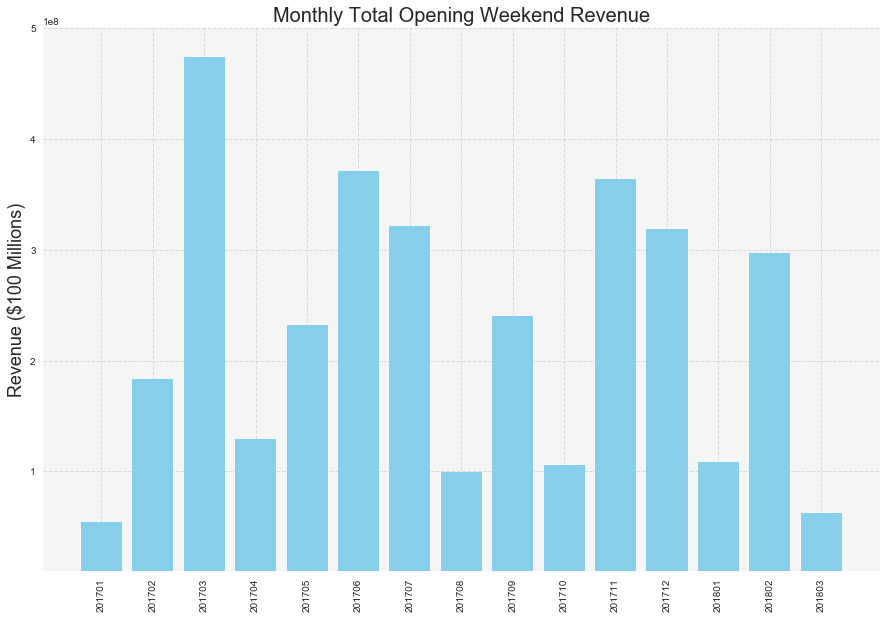

In [12]:
# y-axis for the plot (opening revenue)
opening_weekend_rev_y = opening_weekend_rev_df["total opening by month"]

# x-axis for the plot (release data)
date_open_x = opening_weekend_rev_df["release"]

# plot the barplot
bar_plot = plt.bar(date_open_x, opening_weekend_rev_y, alpha=1, align="edge", color="skyblue")
# (Or) using seaborn

# Tell matplotlib where we would like to place each of our x axis headers
tick_locations = np.arange(len(opening_weekend_rev_df))
plt.xticks(tick_locations+0.4, opening_weekend_rev_df["release"], rotation="vertical")

# set the x and y axis limits and labels, chart title and legends 
plt.ylim(10000000, 500000000)
plt.title("Monthly Total Opening Weekend Revenue", fontsize=20)
plt.ylabel("Revenue ($100 Millions)", fontsize=18)
plt.axhline(0)

# Set axes background color
ax = plt.gca()
ax.set_facecolor('whitesmoke')

# Insert grid lines and set behind plot elements
ax.grid(linestyle='--', color='lightgrey', alpha=0.8)
ax.set_axisbelow(True)

# Save our graph and show the graph
plt.savefig("images/RevenueByMonth.png")
plt.show()

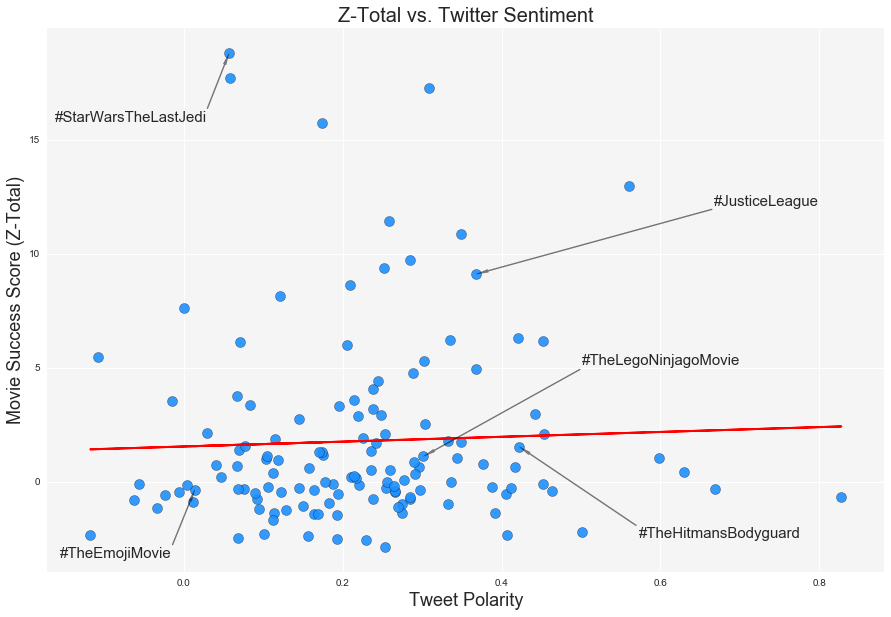

In [13]:
# Set axes
ztotal = movie_data_df['ztotal']
compound = movie_data_df['compound']

# Set movie coordinates
movie_list = ["#TheEmojiMovie", "#JusticeLeague", "#StarWarsTheLastJedi", 
              "#TheHitmansBodyguard", "#TheLegoNinjagoMovie"]

# Set figure size
plt.figure(figsize=(15, 10))

# Create trendline
zx = plt.subplot()
(zslope, zintercept, _, _, _) = stats.linregress(title_index_df['compound'], title_index_df['ztotal'])
zfit = (zslope * title_index_df['compound']) + zintercept
zx.plot(title_index_df['compound'], zfit, color = "r", linewidth = 2)
z_df = pd.DataFrame({"slope":[zslope], "intercept":[zintercept]})

# Create plot
plt.scatter(compound, ztotal, marker="o", s=100, facecolor='dodgerblue', edgecolor='black', alpha=0.9)

# Set limits
# plt.xlim(-1, 1)

# Labels
plt.title('Z-Total vs. Twitter Sentiment', fontsize=20)
plt.xlabel('Tweet Polarity', fontsize=18)
plt.ylabel('Movie Success Score (Z-Total)', fontsize=18)

# Set axes background color
ax = plt.gca()
ax.set_facecolor('whitesmoke')

# Insert grid lines and set behind plot elements
ax.grid(color='white')
ax.set_axisbelow(True)

# Dictionary to hold coordinates for each movie
movie_coord = {}

# Grab coordinates
for movie in movie_list:
    
    # Pinpoint values for coordinates
    coordinate_values = title_index_df.loc[movie,['ztotal', 'compound']]
    
    # Assign coordinates
    x_coord = coordinate_values['compound']
    y_coord = coordinate_values['ztotal']
    
    # Add coordinates for each movie to dictionary
    movie_coord[movie] = [x_coord, y_coord]

# Annotations
ax.annotate("#TheEmojiMovie", xy=(movie_coord["#TheEmojiMovie"][0], movie_coord["#TheEmojiMovie"][1]), 
            xytext=(movie_coord["#TheEmojiMovie"][0]-0.17, movie_coord["#TheEmojiMovie"][1]-3), 
            fontsize=15, arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))
ax.annotate("#JusticeLeague", xy=(movie_coord["#JusticeLeague"][0], movie_coord["#JusticeLeague"][1]), 
            xytext=(movie_coord["#JusticeLeague"][0]+0.3, movie_coord["#JusticeLeague"][1]+3), 
            fontsize=15, arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))
ax.annotate("#StarWarsTheLastJedi", xy=(movie_coord["#StarWarsTheLastJedi"][0], movie_coord["#StarWarsTheLastJedi"][1]), 
            xytext=(movie_coord["#StarWarsTheLastJedi"][0]-0.22, movie_coord["#StarWarsTheLastJedi"][1]-3), 
            fontsize=15, arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))
ax.annotate("#TheHitmansBodyguard", xy=(movie_coord["#TheHitmansBodyguard"][0], movie_coord["#TheHitmansBodyguard"][1]), 
            xytext=(movie_coord["#TheHitmansBodyguard"][0]+0.15, movie_coord["#TheHitmansBodyguard"][1]-4), 
            fontsize=15, arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))
ax.annotate("#TheLegoNinjagoMovie", xy=(movie_coord["#TheLegoNinjagoMovie"][0], movie_coord["#TheLegoNinjagoMovie"][1]), 
            xytext=(movie_coord["#TheLegoNinjagoMovie"][0]+0.20, movie_coord["#TheLegoNinjagoMovie"][1]+4), 
            fontsize=15, arrowprops=dict(facecolor='black', width=1, headwidth=3, shrink=.001, alpha=0.5))

# Save and show
plt.savefig('images/ZtotalVsTwitterSentiment.png')
plt.show()

In [14]:
# Check slope
z_df

,intercept,slope
0,1.548895,1.061674


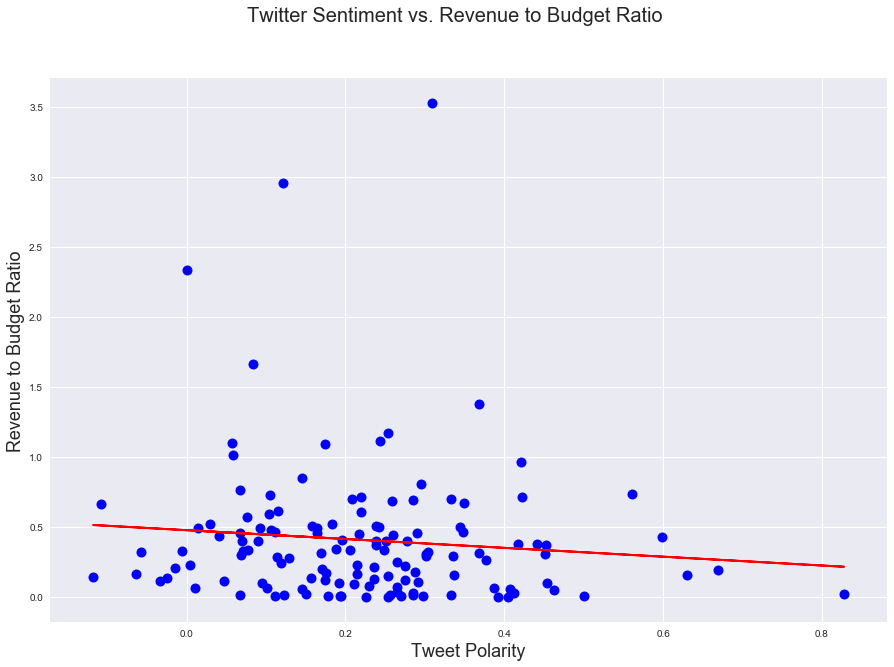

In [ ]:
#8 maybe a scatter plot of twitter sentiment and budget/rev ratio

fig, brx = plt.subplots(figsize=(15, 10))
# plt.figure(figsize=(10,7))

(brslope, brintercept, _, _, _) = stats.linregress(movie_data_df['compound'], movie_data_df['ratio'])
brfit = (brslope * movie_data_df['compound']) + brintercept
brx.plot(movie_data_df['compound'], brfit, color = "red", linewidth = 2)
brx.scatter(movie_data_df['compound'], movie_data_df['ratio'], s = 100, linewidth=0, marker="o", color="blue", label = None)

brx.set_ylabel("Revenue to Budget Ratio", size=18)
brx.set_xlabel("Tweet Polarity", size=18)
# brx.legend (loc='best', bbox_to_anchor=(1,1))
fig.suptitle('Twitter Sentiment vs. Revenue to Budget Ratio', size=20)

plt.savefig("images/SentimentVsBRRatio.png")
plt.show()

In [ ]:
#Prediction via Regression
daily_movie_sentiment = pd.read_csv('prediction_data/daily_movie_sentiment.csv')
daily_movie_sentiment['product'] = ""
for index, row in daily_movie_sentiment.iterrows():
    p = row['Compound'] * row['Tweet Count']
    daily_movie_sentiment.set_value(index, "product", p)
daily_movie_sentiment = daily_movie_sentiment.groupby(['Movie Title'])
total_tweets = daily_movie_sentiment['Tweet Count'].sum()
total_score = daily_movie_sentiment['product'].sum()
sentiment = total_score/total_tweets
predictor_movies = pd.DataFrame({"sentiment":sentiment})
predictor_movies = predictor_movies.reset_index()
movie_query = input("What Movie would you like to search? ")
omdbapi = "e8913e4c"
omdb1 = "http://www.omdbapi.com/?t="
omdb2 = "&apikey="
moviedbapi = "87594855563381b8f9fa3b3224c9f19f"
idURL = "https://api.themoviedb.org/3/search/movie?query="
idURL1 = "&api_key="
detailURL = "https://api.themoviedb.org/3/movie/"
detailURL1 = "?api_key="
#prepare to search by twitter hashtag
movie_search = movie_query.replace(" ","")
movie_search = movie_search.replace(":","")
movie_search = movie_search.replace("’","")
movie_search = movie_search.replace(".","")
movie_search = movie_search.replace(",","")
movie_search = movie_search.replace("!","")
movie_search = movie_search.replace("?","")
movie_search = movie_search.replace("-","")
movie_search = movie_search.replace("&","")
movie_search = movie_search.replace("$","")
movie_search = "#" + movie_search
# print (movie_query)
# print (f'Searching Twitter for {movie_search}')
try:
    n = 0
    for index, row in predictor_movies.iterrows():
        if row['Movie Title'] == movie_search:
            s_index = n
        else:
            n = n + 1
    twitter_compound = predictor_movies['sentiment'][s_index]
#     print (twitter_compound)
        
except:
    publicTweets = api.search(movie_search, count = 100)
    compoundList = []
    for tweet in publicTweets['statuses']:
        text = tweet['text']
        results = analyzer.polarity_scores(text)
        compound = results['compound']
        compoundList.append(compound)
    twitter_compound = np.mean([compoundList])
print (f'{movie_query} has a Vader Compound Score of {twitter_compound.round(2)}')
#-----------------------------------------------------------------------
# print ('Searching API')
omdb_url = omdb1 + movie_query + omdb2 + omdbapi
# print (omdb_url)
try:
    q_json = requests.get(omdb_url).json()
    rated = q_json['Rated']
    rated_col = r_df['rated']
#     print(rated_col)
    counter = 0
    for name in rated_col:
        if name == rated:
            r_index = counter
        else:
            counter = counter + 1
    r_int = r_df['intercept'][r_index]
    r_m = r_df['slope'][r_index]
    rscore = (r_int + (r_m * twitter_compound)).round(2)
    print (f'{movie_query} is rated: {rated}')
    print (f'Based on this rating, we expect a Movie Success Score of {rscore}')
    
except:
    print (f'Could not find rating for {movie_query}')
    
print ("---------------------------------------------------------------------------------")
id_query = idURL + movie_query + idURL1 + moviedbapi
# print (id_query)
try:
    moviedbquery = requests.get(id_query).json()
    movie_idnumber = moviedbquery['results'][0]['id']
#     print (movie_idnumber)
    details_URL = detailURL + str(movie_idnumber) + detailURL1 + moviedbapi
#     print (details_URL)
    details_URL_json = requests.get(details_URL).json()
    genreList = []
    for entry in details_URL_json['genres']:
#         print (entry)
        g_name = entry['name']
        genreList.append(g_name)
#     print (genreList)
    for genre in genreList:
        for g in genres:
            if genre == g:
                matchGenre = genre
    g_counter = 0
    for name in genres:
        if name == matchGenre:
            g_index = g_counter
        else:
            g_counter = g_counter + 1
#     print (g_index)
    g_int = g_df['intercept'][g_index]
#     print (g_int)
    g_m = g_df['slope'][g_index]
#     print (g_m)
    g_score = (g_int + (g_m * twitter_compound)).round(2)
    print (f"{movie_query} has the genre: {matchGenre}")
    print (f'Based on this genre, we expect a Movie Success Score of {g_score}')
except:
    print (f"Could not find a genre match for {movie_query}")
print ("---------------------------------------------------------------------------------")
z_score = (zintercept + (zslope * twitter_compound)).round(2)
print (f'Based on Vader Sentiment Analysis, we expect an overall Movie Success Score of {z_score}')